In [287]:

import os
import sys
import pandas as pd


TOOL_TAGS = {
	'COTAN': 'COTAN',
	'seurat': 'Seurat',
	'scanpy': 'Scanpy',
	'monocle':'Monocle',
	'scvi-tools': 'scvi-tools',
}

markers_lists = {
	'endothelial cell': ['Fabp4', 'Cdh5', 'Cav1'],
	'fibroblast': ['Ddr2', 'Tcf21', 'Col3a1', 'Col1a2', 'Col1a1', 'Myh11', 'Tcf21'],
	'cardiac muscle cell': ['Nppa', 'Myl7', 'Sln'],
	'endocardial cell': ['Npr3', 'Pecam1'],
}

TOP_K = [10,30,50]

path = '../results/aggregate/tabula-muris-heart/truth_markers.csv'
showPlot = not sys.argv[2].endswith('False')

scores_df = pd.read_csv(path)
print(scores_df)
scores_df['tool'] = scores_df['tool'].apply(lambda x: TOOL_TAGS[x])
scores_df = scores_df[scores_df['truth_label']!='unknown cluster']

scores_df.head()

      gene  cluster  rank        tool       truth_label
0    Fabp4        4     2     monocle  endothelial cell
1    Fabp4        4     1      scanpy  endothelial cell
2    Fabp4        4     1      seurat  endothelial cell
3    Fabp4        4     8  scvi-tools  endothelial cell
4     Cdh5        4    11     monocle  endothelial cell
..     ...      ...   ...         ...               ...
61    C1qa        1     5      seurat       immune cell
62  H2-Eb1        1    21     monocle       immune cell
63  H2-Eb1        1    47      scanpy       immune cell
64  H2-Eb1        1     8      seurat       immune cell
65  H2-Eb1        1    50  scvi-tools       immune cell

[66 rows x 5 columns]


,gene,cluster,rank,tool,truth_label
0,Fabp4,4,2,Monocle,endothelial cell
1,Fabp4,4,1,Scanpy,endothelial cell
2,Fabp4,4,1,Seurat,endothelial cell
3,Fabp4,4,8,scVI-tools,endothelial cell
4,Cdh5,4,11,Monocle,endothelial cell


In [288]:
# read go mapping
go_df = pd.read_csv('../dataset/tabula-muris-heart-filtered/mapping.csv')
go_df = go_df.sort_values(by=['id'])
go_map = {cluster_id: go for cluster_id, go in zip(go_df['id'], go_df['go'])}
go_map

{1: 'unknown cluster',
 2: 'cardiac muscle cell',
 3: 'endocardial cell',
 4: 'endothelial cell',
 5: 'fibroblast'}

In [289]:
sorted(scores_df['truth_label'].unique())

['cardiac muscle cell',
 'endocardial cell',
 'endothelial cell',
 'fibroblast',
 'immune cell']

In [290]:
# merge myofibroblast and fibroblast
scores_df['truth_label'] = scores_df['truth_label'].apply(lambda x: 'fibroblast' if x == 'myofibroblast' else x)

# add cluster go for predcited clusters
scores_df['predicted_label'] = scores_df['cluster'].map(go_map)

# filter only right guesses of tools following go mapping
scores_df = scores_df[scores_df['truth_label'] == scores_df['predicted_label']]
scores_df = scores_df.drop(columns=['predicted_label'])
scores_df.head()

,gene,cluster,rank,tool,truth_label
0,Fabp4,4,2,Monocle,endothelial cell
1,Fabp4,4,1,Scanpy,endothelial cell
2,Fabp4,4,1,Seurat,endothelial cell
3,Fabp4,4,8,scVI-tools,endothelial cell
4,Cdh5,4,11,Monocle,endothelial cell


In [291]:
found_clusters = sorted(scores_df['truth_label'].unique())
tool_count = len(scores_df['tool'].unique())

In [292]:
# For each cluster, count the number of genes found by each tool
scores_df_grouped = pd.DataFrame(columns=['truth_label', 'tool'])
for top in TOP_K:
    score = "top_" + str(top)
    cur_df = scores_df[scores_df['rank'] <= top].copy()
    # get percentage of genes found by each tool per cluster
    grouped = cur_df.groupby(['truth_label', 'tool']).apply(lambda x: len(x)/len(markers_lists[x['truth_label'].iloc[0]]))
    cur_df = pd.DataFrame(grouped, columns=[score]).reset_index()
    # merge results of current score
    scores_df_grouped = pd.merge(scores_df_grouped, cur_df, how='outer', on=['truth_label', 'tool'])
scores_df_grouped = scores_df_grouped.fillna(0)

# round scores to 2 decimal places and compute as percentage
for top in TOP_K:
    score = "top_" + str(top)
    scores_df_grouped[score] = scores_df_grouped[score].apply(lambda x: round(x, 2))

scores_df_grouped

,truth_label,tool,top_10,top_30,top_50
0,cardiac muscle cell,Monocle,1.00,1.00,1.00
1,cardiac muscle cell,Scanpy,1.00,1.00,1.00
2,cardiac muscle cell,Seurat,1.00,1.00,1.00
3,endocardial cell,COTAN,0.50,0.50,0.50
4,endocardial cell,Monocle,0.50,0.50,1.00
5,endocardial cell,Scanpy,0.50,0.50,1.00
6,endocardial cell,Seurat,0.50,0.50,1.00
7,endocardial cell,scVI-tools,0.50,0.50,0.50
8,endothelial cell,COTAN,0.33,0.33,0.33
9,endothelial cell,Monocle,0.33,1.00,1.00


In [293]:
test = scores_df_grouped[scores_df_grouped['tool'] == "COTAN"]
test

,truth_label,tool,top_10,top_30,top_50
3,endocardial cell,COTAN,0.50,0.50,0.50
8,endothelial cell,COTAN,0.33,0.33,0.33
13,fibroblast,COTAN,0.43,0.71,0.86


In [294]:
##### plot

import matplotlib.pyplot as plt
import numpy as np

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('Set2').colors)

SCORES = ["top_" + str(top) for top in TOP_K]


score_dict = {}
for score in SCORES:
	means = {}
	for tool in TOOL_TAGS.values():
		tool_scores = scores_df_grouped[scores_df_grouped['tool'] == tool]
		if not tool_scores.empty:
			tool_scores = tool_scores.sort_values(by='truth_label')
			# generate tuple of scores for each dataset in order with zero for missing labels
			means[tool] = [tool_scores[tool_scores['truth_label'] == cluster][score].iloc[0] if cluster in tool_scores['truth_label'].values else 0 for cluster in found_clusters]
	score_dict[score] = means
score_dict

{'top_10': {'COTAN': [0, 0.5, 0.33, 0.43],
  'Seurat': [1.0, 0.5, 0.67, 0.29],
  'Scanpy': [1.0, 0.5, 1.0, 0.43],
  'Monocle': [1.0, 0.5, 0.33, 0.71],
  'scVI-tools': [0.0, 0.5, 0.67, 0.29]},
 'top_30': {'COTAN': [0, 0.5, 0.33, 0.71],
  'Seurat': [1.0, 0.5, 1.0, 0.71],
  'Scanpy': [1.0, 0.5, 1.0, 0.71],
  'Monocle': [1.0, 0.5, 1.0, 0.71],
  'scVI-tools': [0.67, 0.5, 0.67, 0.71]},
 'top_50': {'COTAN': [0, 0.5, 0.33, 0.86],
  'Seurat': [1.0, 1.0, 1.0, 0.71],
  'Scanpy': [1.0, 1.0, 1.0, 0.71],
  'Monocle': [1.0, 1.0, 1.0, 0.71],
  'scVI-tools': [1.0, 0.5, 1.0, 0.71]}}

In [295]:
def score_bar_plot(penguin_data, found_clusters, tool_count, score, percentage=True):
    means = penguin_data[score]
    x = np.arange(len(found_clusters))  # the label locations
    width = 1/(tool_count+1)  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(21,9))
    max_height = 1
    min_height = 0

    for attribute, measurement in means.items():
        # max in mesurement
        if percentage:
            measurement = tuple(x * 100 for x in measurement)
        max_measurement = max(measurement)
        if max_measurement > max_height:
            max_height = max_measurement
        min_measurement = min(measurement)
        if min_measurement < min_height:
            min_height = min_measurement

        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=-20, fontsize=12)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if percentage:
        ax.set_ylabel('Markers found %', fontsize=14)
    else:
        ax.set_ylabel('Markers found', fontsize=14)
    ax.set_title(score.replace('_', ' '), fontsize=14)
    ax.set_xticks(x + 2*width, found_clusters, rotation=45, fontsize=12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
    ax.set_ylim(min_height, max_height) 

    plt.savefig('../results/aggregate/tabula-muris-heart/markers-hist-' + score + '.png', bbox_inches='tight')
    plt.savefig('../results/aggregate/tabula-muris-heart/markers-hist-' + score + '.eps', bbox_inches='tight')
    if showPlot: plt.show()

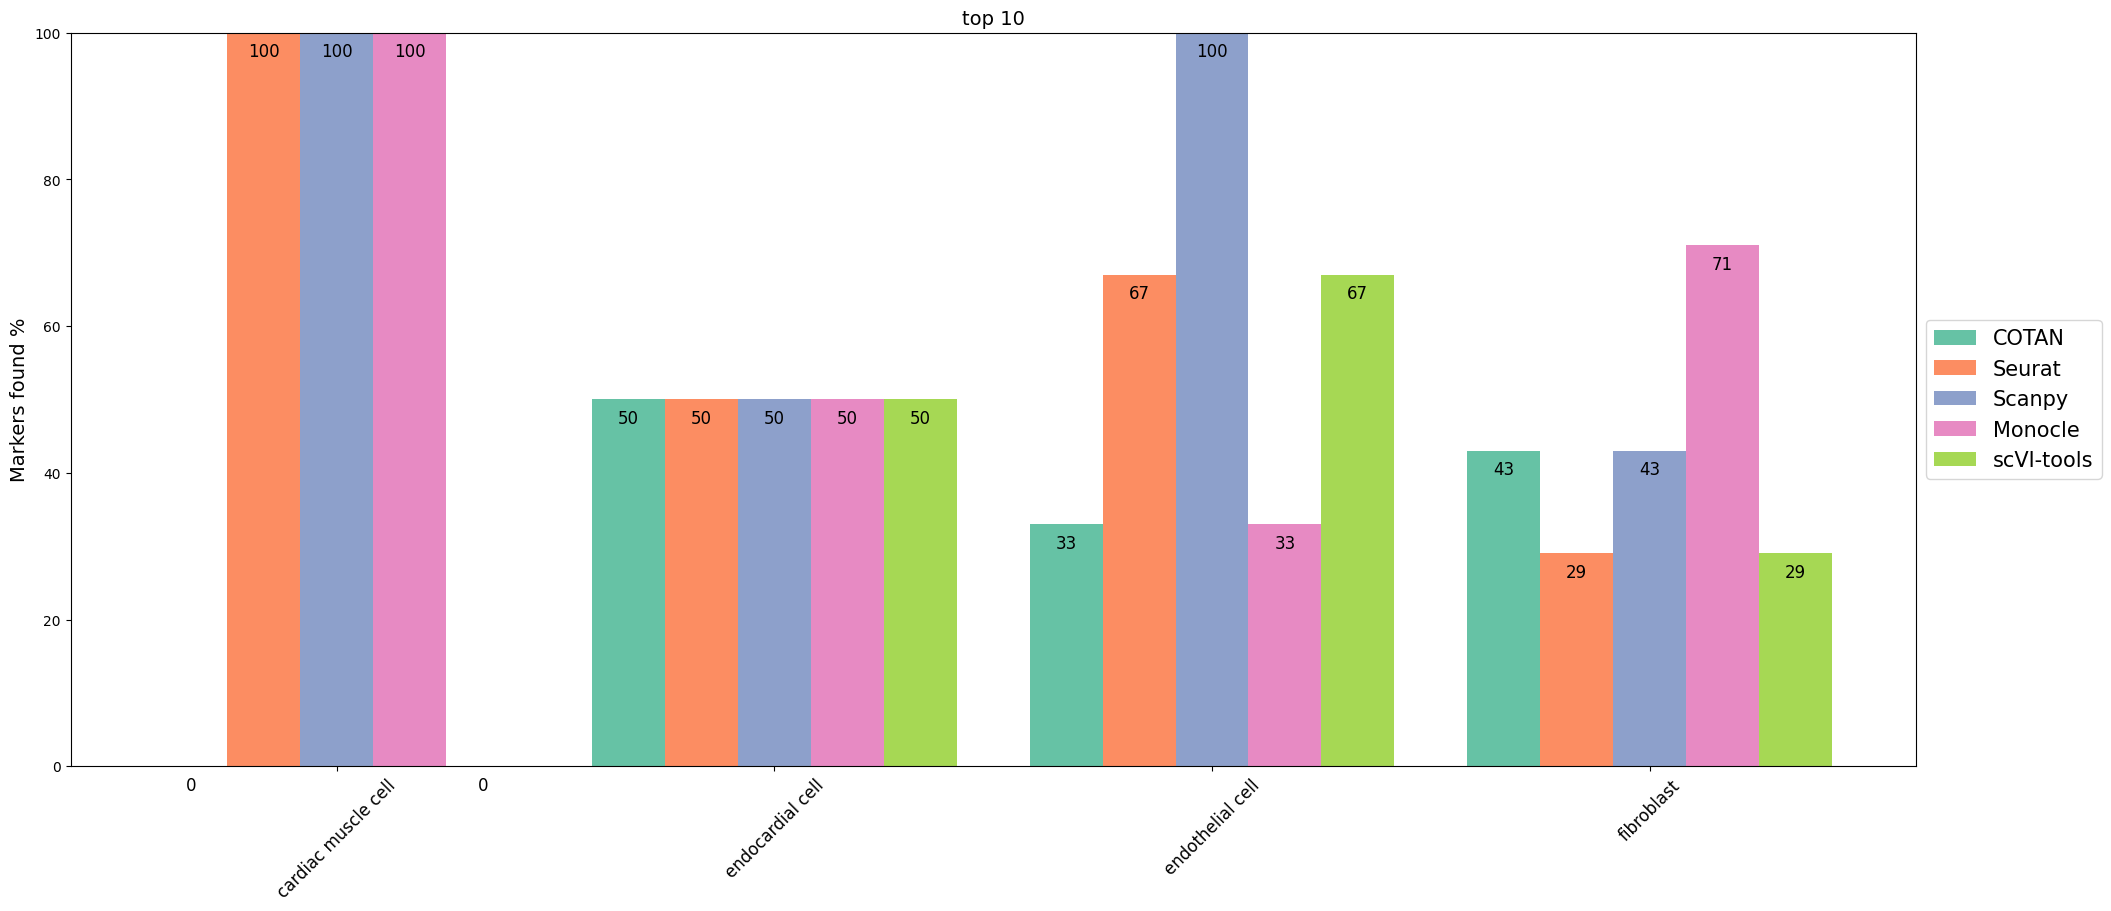

In [296]:
score_bar_plot(score_dict, found_clusters, tool_count, score='top_10')

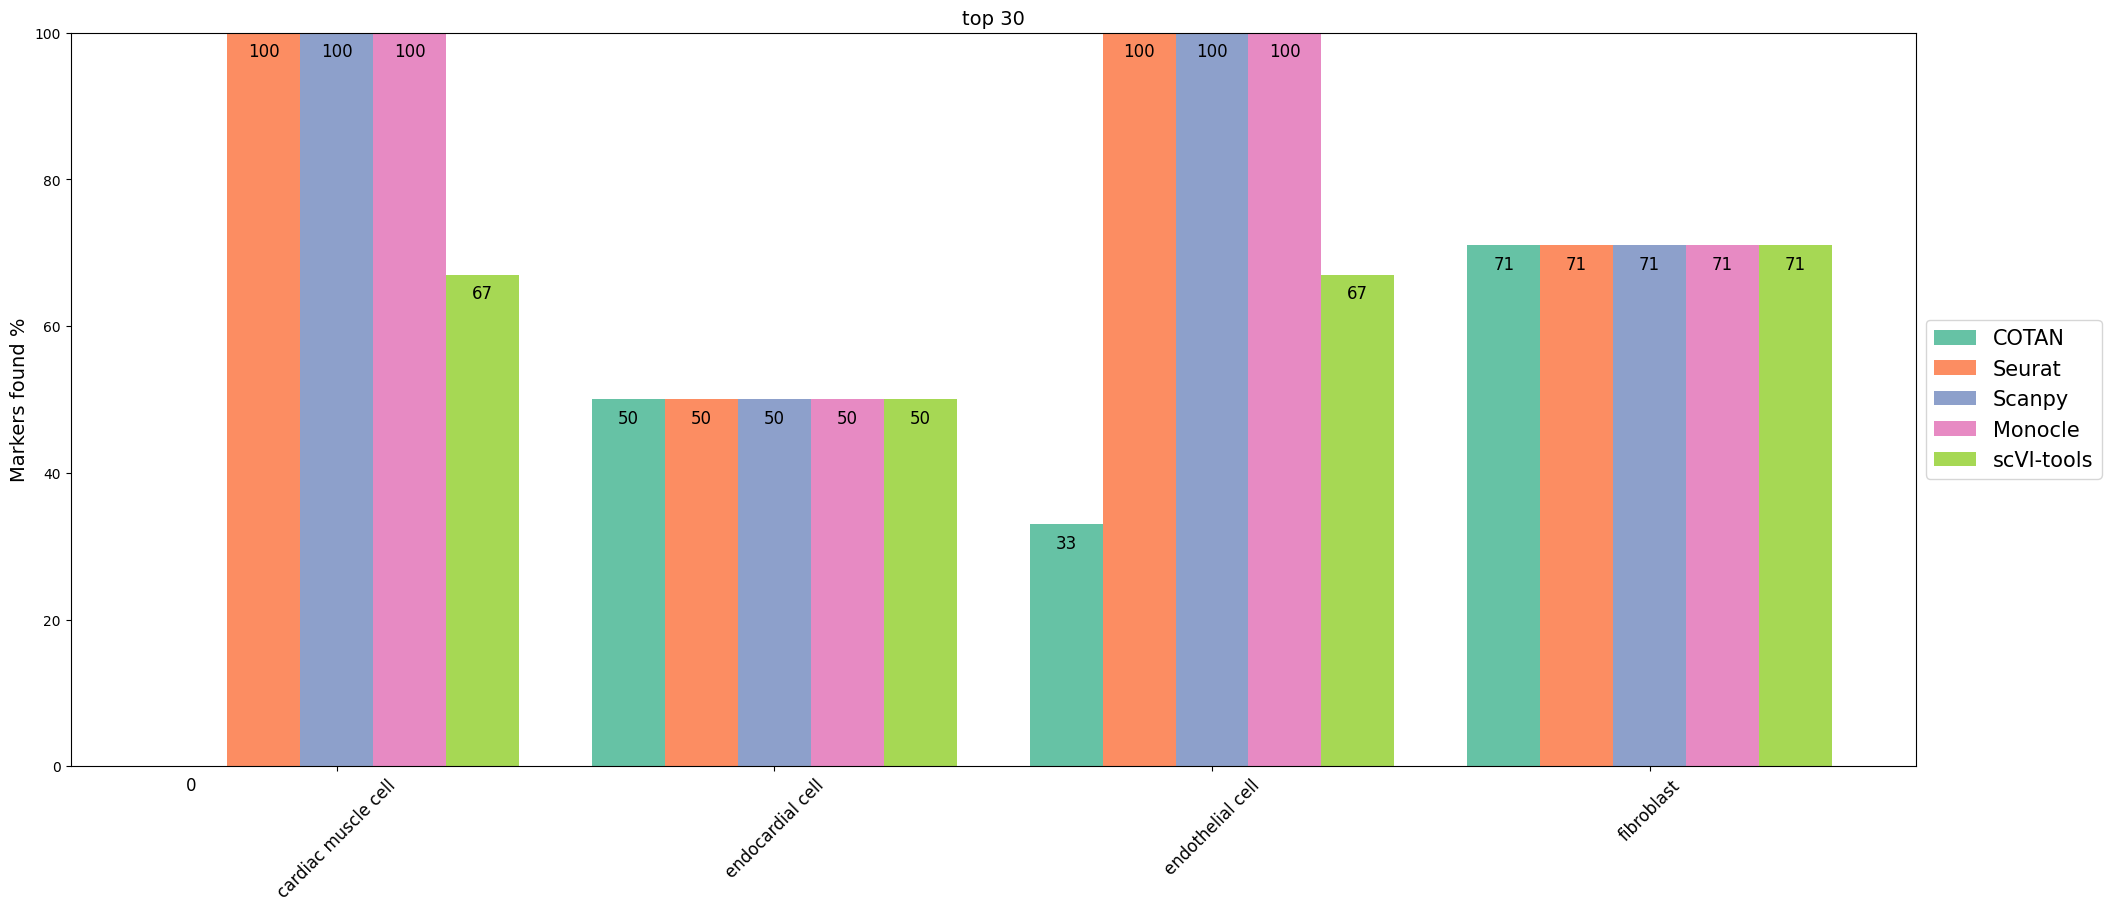

In [297]:
score_bar_plot(score_dict, found_clusters, tool_count, score='top_30')

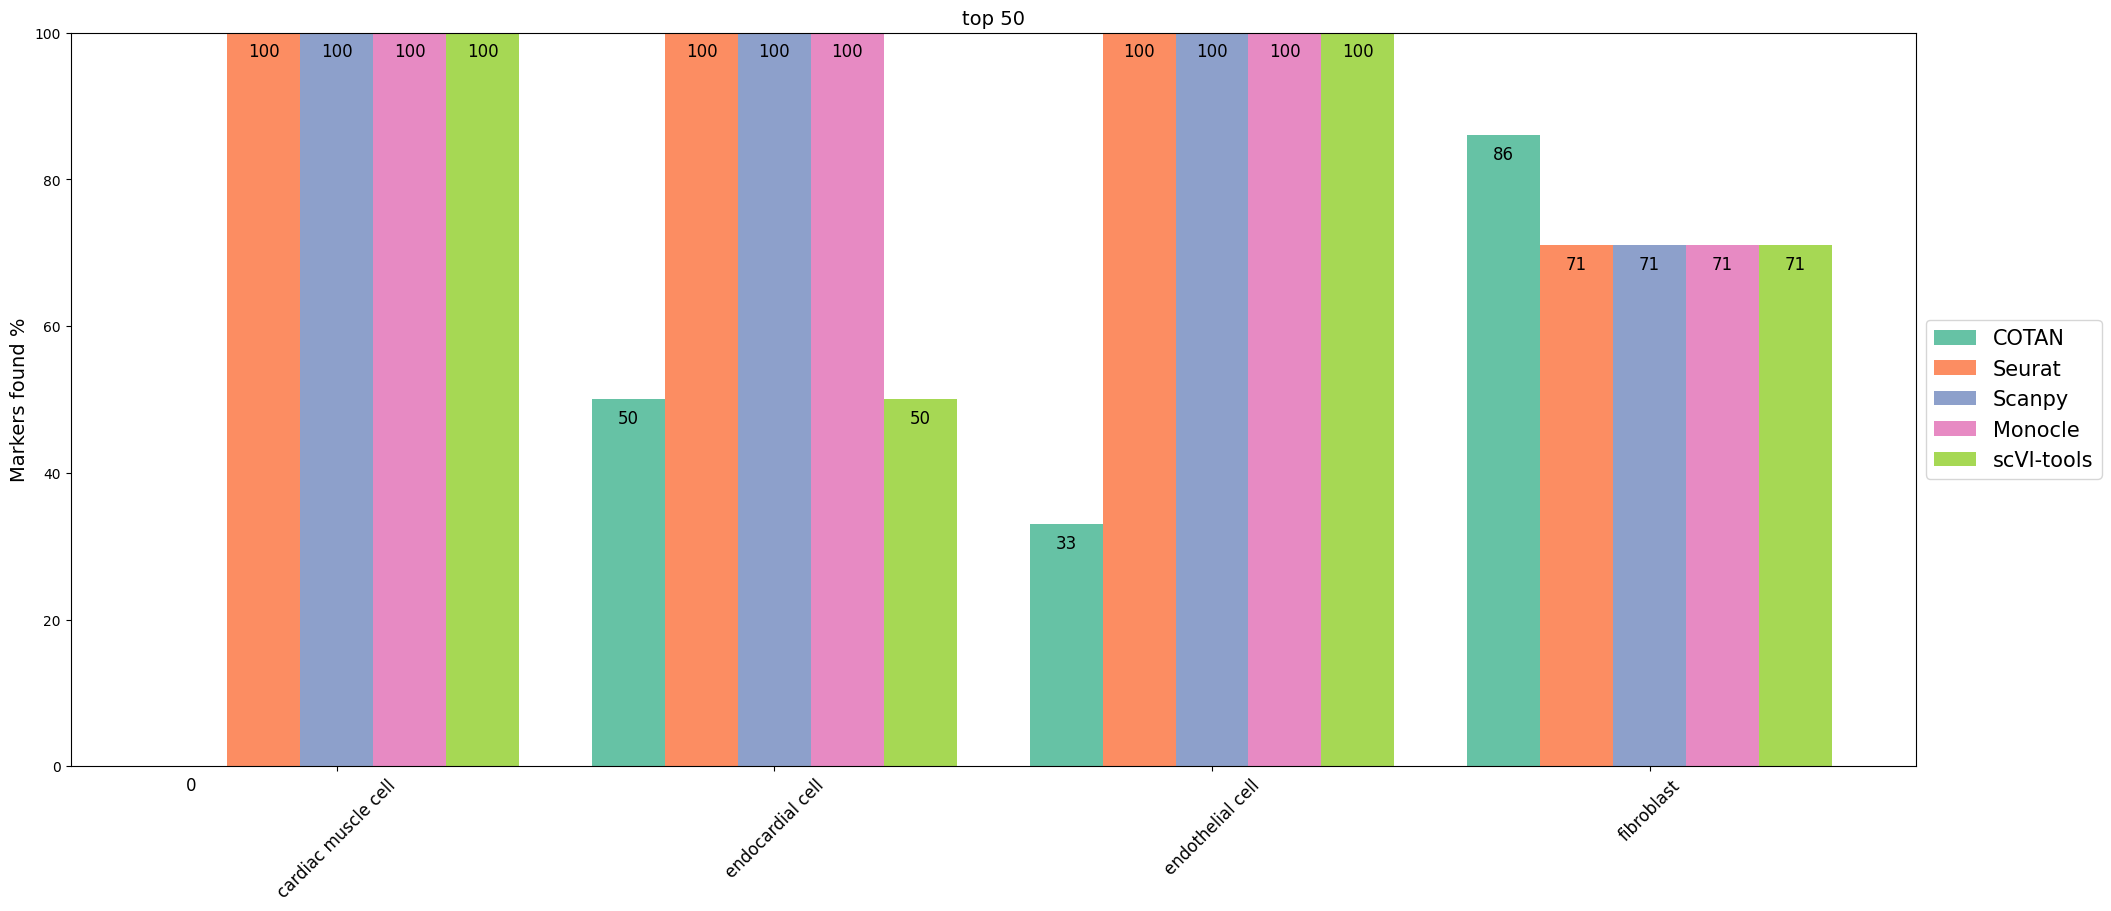

In [298]:
score_bar_plot(score_dict, found_clusters, tool_count, score='top_50')